# ***Visualization***

In [1]:
# %matplotlib inline
import mysql.connector
from mysql.connector import Error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import numpy as np

In [2]:
def connect_to_database(host, port, database, username, password):
    """
    Function for connecting to the database.
    :param host: Name of the host.
    :param port: Number of the port.
    :param database: Name of the database.
    :param username: Username.
    :param password: Password to  the database.
    :return: Database connection object.
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host,
            port=port,
            database=database,
            user=username,
            password =password
        )
        print("Connection successful!")
    except Error as err:
        print(f"Error ocured: {err}.")
    return connection

def read_query(connection, query):
    """
    Function to access stats from database. Used in the function prepare_data(). 
    :param connection: Database connection object.
    :param query: SQL query.
    :return: Tuple of the desired stats.
    """
    cur = connection.cursor()
    result = None
    try:
        cur.execute(query)
        result = cur.fetchall()
        return result
    except Error as err:
        print(f"Error occured: '{err}'")
        
def prepare_data(query, connection, columns):
    """
    Function preparing data from the database to be easily plotted.
    :param connection: Database connection object.
    :param query: SQL query.
    :param columns: Columns of the DataFrame.
    :return: DataFrame object of the stats.
    """
    results = read_query(connection, query)
    to_db = []
    for res in results:
        res = list(res)
        to_db.append(res)
        
    df = pd.DataFrame(to_db, columns=columns)
    return df

def show_image(img):
    """
    Function to cope with Github error and show images of the plots.
    :param img: Name of the file (image) to  be displayed.
    :return: Plot of the image
    """
    img = mpimg.imread(img)
    plt.figure(figsize=(10,7), dpi=1200)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
con = connect_to_database(
    host="****",
    port="****",
    database="****",
    username="****",
    password="****"
)

Connection successful!


In [4]:
team_colors = {
    'Arsenal': 'rgb(255, 0, 0)',
    'Aston Villa': 'rgb(48, 25, 52)',
    'Bournemouth': 'rgb(222, 49, 99)',  
    'Brentford': 'rgb(255, 127, 127)',  
    'Brighton': 'rgb(0, 0, 255)',  
    'Chelsea': 'rgb(42, 82, 190)', 
    'Crystal Palace': 'rgb(128, 0, 128)',  
    'Everton': 'rgb(3, 80, 150)',  
    'Fulham': 'rgb(128, 128, 128)',
    'Leeds': 'rgb(255, 255, 0)',  
    'Leicester': 'rgb(0, 0, 139)',
    'Liverpool': 'rgb(139, 0, 0)',
    'Manchester City': 'rgb(173, 216, 230)',
    'Manchester United': 'rgb(255, 0, 0)', 
    'Newcastle': 'rgb(0, 0, 0)',  
    'Nottingham Forest': 'rgb(34, 139, 34)',
    'Southampton': 'rgb(255, 192, 203)',  
    'Tottenham': 'rgb(169, 169, 169)',  
    'West Ham': 'rgb(210, 105, 30)',  
    'Wolves': 'rgb(255, 165, 0)'  
}

## ***Expected Goals vs Scored Goals***

Plot shows top 50 goalscorers of the season and shows relationship between scored goals and xG. As you can see on the plot more than 2/3 of them scored more goals than would be expected from the stats.

**xG** or **“Expected Goals”**:
It's a statistical measure used to quantify the quality of shooting opportunities and the likelihood of them being converted into goals. Each shot is compared to thousands of similar shots from the past to determine the likelihood of that shot resulting in a goal. The xG metric takes into account many factors such as distance from goal, angle of shot, type of shot (header, shot with foot), type of pass leading to the shot, as well as the context of the situation (e.g., whether it was a set-piece situation, or after a ball recovery).

In [5]:
q1 = """
SELECT t.name AS Team, p.name AS Player_Name, ps.gls AS Goals, ps.xG AS xG FROM playerSht ps
JOIN player p
ON p.id = ps.player_id
JOIN team t
ON t.id = p.team_id
ORDER BY Goals DESC
LIMIT 50
"""
cols = ['Team', 'Player', 'Goals', 'xG']

df = prepare_data(q1, con, cols)

fig = px.scatter(df, x='xG', y='Goals', color='Team', hover_data=['Player'], color_discrete_map=team_colors)

fig.add_trace(
    go.Scatter(
        x=[0, 40],
        y=[0, 40],
        mode='lines',
        line=dict(color='red', dash='dash'),
        showlegend=False
    )
)

above_line = np.sum(df['Goals'] > df['xG'])
below_line = np.sum(df['Goals'] < df['xG'])
total = len(df)

perc_above = int(above_line / total * 100)
perc_below = int(below_line / total * 100)

fig.add_annotation(
    x=0.15, y=0.80, xref='paper', yref='paper',
    text=f'{perc_above}%',
    font=dict(family='Cambria Math', size=50, color='black'),
    opacity=0.5,
    showarrow=False
)
fig.add_annotation(
    x=0.85, y=0.15, xref='paper', yref='paper',
    text=f'{perc_below}%',
    font=dict(family='Cambria Math', size=50, color='black'),
    opacity=0.5,
    showarrow=False
)

fig.update_layout(
    title='Expected Goals (xG) vs Scored Goals', 
    title_x=0.5, 
    title_font=dict(size=25, family='Cambria Math', color='black'),
    autosize=False, 
    width=900, 
    height=600
)

fig.update_xaxes(range=[0,40], title_font=dict(size=18, family='Cambria Math', color='black'))
fig.update_yaxes(range=[0,40], title_font=dict(size=18, family='Cambria Math', color='black'))


fig.show()

**NOTE:** Due to the Github error, plots created with plotly library aren't displayed. 
So for Github purposes I also show image of the plot (for obvious reasons it isn't interactive - like `plotly` plot).

In [6]:
show_image('plots/xg_sg.png')

## ***Expected Assists vs Provided Assists***


**xA** or **“Expected Assists”**:
It's the equivalent of xG focusing on quantifying the quality of passes that lead to shots. This metric assigns a value between 0 and 1 to each pass or cross that leads to a shot attempt. Similar to xG, xA calculations take into account factors such as the type of pass, distance, angle, and nature of the created opportunity. The xA value is assigned to every successful pass, as any completed pass can become an assist.


In [7]:
q2 = """
SELECT t.name AS Team, p.name AS Player, pp.ast AS Assists, pp.xA AS xA 
FROM playerPass pp
JOIN player p
ON p.id = pp.player_id
JOIN team t
ON t.id = p.team_id
ORDER BY Assists DESC
LIMIT 50
"""

cols = ['Team', 'Player', 'Assists', 'xA']

df = prepare_data(q2, con, cols)

fig = px.scatter(df, x='xA', y='Assists', color='Team', hover_data=['Player'], color_discrete_map=team_colors)

fig.add_trace(
    go.Scatter(
        x=[0,18],
        y=[0,18],
        mode='lines',
        line=dict(color='red', dash='dash'),
        showlegend=False
    )  
)

above_line = np.sum(df.Assists > df.xA)
below_line = np.sum(df.Assists < df.xA)
total = len(df)

perc_above = int(above_line/total * 100)
perc_below = int(below_line/total * 100)

fig.add_annotation(
    x=0.15, y=0.85, xref='paper', yref='paper',
    font=dict(family='Cambria Math', size=50, color='black'),
    text=f'{perc_above}%',
    opacity=0.5,
    showarrow=False
)

fig.add_annotation(
    x=0.85, y=0.15, xref='paper', yref='paper',
    font=dict(family='Cambria Math', size=50, color='black'),
    text=f'{perc_below}%',
    opacity=0.5,
    showarrow=False
)

fig.update_layout(
    title='Expected Assists vs Provided Assists',
    title_x=0.5,
    title_font=dict(family='Cambria Math', size=25, color='black'),
    width=900, 
    height=600
)

fig.update_xaxes(range=[0,18], title_font=dict(family='Cambria Math', size=18, color='black'))
fig.update_yaxes(range=[0,18], title_font=dict(family='Cambria Math', size=18, color='black'))

fig.show()

**NOTE:** Due to the Github error, plots created with plotly library aren't displayed. 
So for Github purposes I also show image of the plot (for obvious reasons it isn't interactive - like `plotly` plot).

In [8]:
show_image('plots/xa_pa.png')

## ***Shot and Goal Creation***

**First plot** shows the amount of shot-creating actions (SCA) made by each team. By **SCA** we mean the two offensive actions directly leading to a shot, such as passes, take-ons and drawing fouls.

**Second plot** shows the amount of goal-creating actions (GCA) made by each team. By **GCA** we mean the two offensive actions directly leading to a goal, such as passes, take-ons and drawing fouls. It’s important to note that GCA is a subset of SCA.

**Third plot** reveals the proportion of SCA that is GCA, represented by percentage values within each bar.

Upon observation, the first plot exhibits less variability compared to the second one. This could suggest that while the creation of scoring opportunities (SCA) is relatively consistent across teams, the conversion of these opportunities into goals (GCA) varies more significantly. This variability in GCA could be influenced by factors such as the quality of the finish, the skill of the players, or the effectiveness of the team’s tactics.

Interestingly, despite the Wolves ranking as the fourth lowest team in the SCA statistics and the lowest in the GCA statistics, they managed to avoid relegation. In fact, they secured the 13th position last season. This could indicate that the team’s defensive performance or other aspects of their game played a significant role in their success.

In [9]:
q3 = """
SELECT t.name AS Team, tg.sca AS SCA, tg.sca_pl AS pass_live, tg.sca_pd AS pass_dead, tg.sca_to AS take_ons
FROM teamGSC as tg
JOIN team t
ON t.id = tg.team_id
"""
cols = ['Team', 'SCA', 'Pass_Live', 'Pass_Dead', 'Take_Ons']

df_sca = prepare_data(q3, con, cols)

df_sca['Others'] = df_sca['SCA'] - df_sca[['Pass_Live', 'Pass_Dead', 'Take_Ons']].sum(axis=1)
df_pivot_sca = df_sca.melt(id_vars=['Team', 'SCA'], value_vars=['Pass_Live', 'Pass_Dead', 'Take_Ons', 'Others'], var_name='Type', value_name='Amount')

total_amount = df_pivot_sca.groupby('Team')['Amount'].sum().reset_index()
df_pivot_sca = pd.merge(df_pivot_sca, total_amount, on='Team', suffixes=('', '_Total'))
df_pivot_sca = df_pivot_sca.sort_values('Amount_Total', ascending=False)

fig = px.bar(
    df_pivot_sca,
    x='Team', y='Amount', color='Type',
    color_discrete_sequence=px.colors.qualitative.G10,
    category_orders={'Type': ['Pass_Live', 'Pass_Dead', 'Take_Ons', 'Others']}    
)

fig.update_layout(
    title='Shot-Creating Actions By Teams',
    title_x=0.5,
    title_font=dict(family='Cambria Math', size=25, color='black')
)

fig.update_yaxes(range=[0, 1200], title_font=dict(family='Cambria Math', size=18, color='black'), nticks=10)
fig.update_xaxes(title_font=dict(family='Cambria Math', size=18, color='black'))

fig.show()

**NOTE:** Due to the Github error, plots created with plotly library aren't displayed. 
So for Github purposes I also show image of the plot (for obvious reasons it isn't interactive - like `plotly` plot).

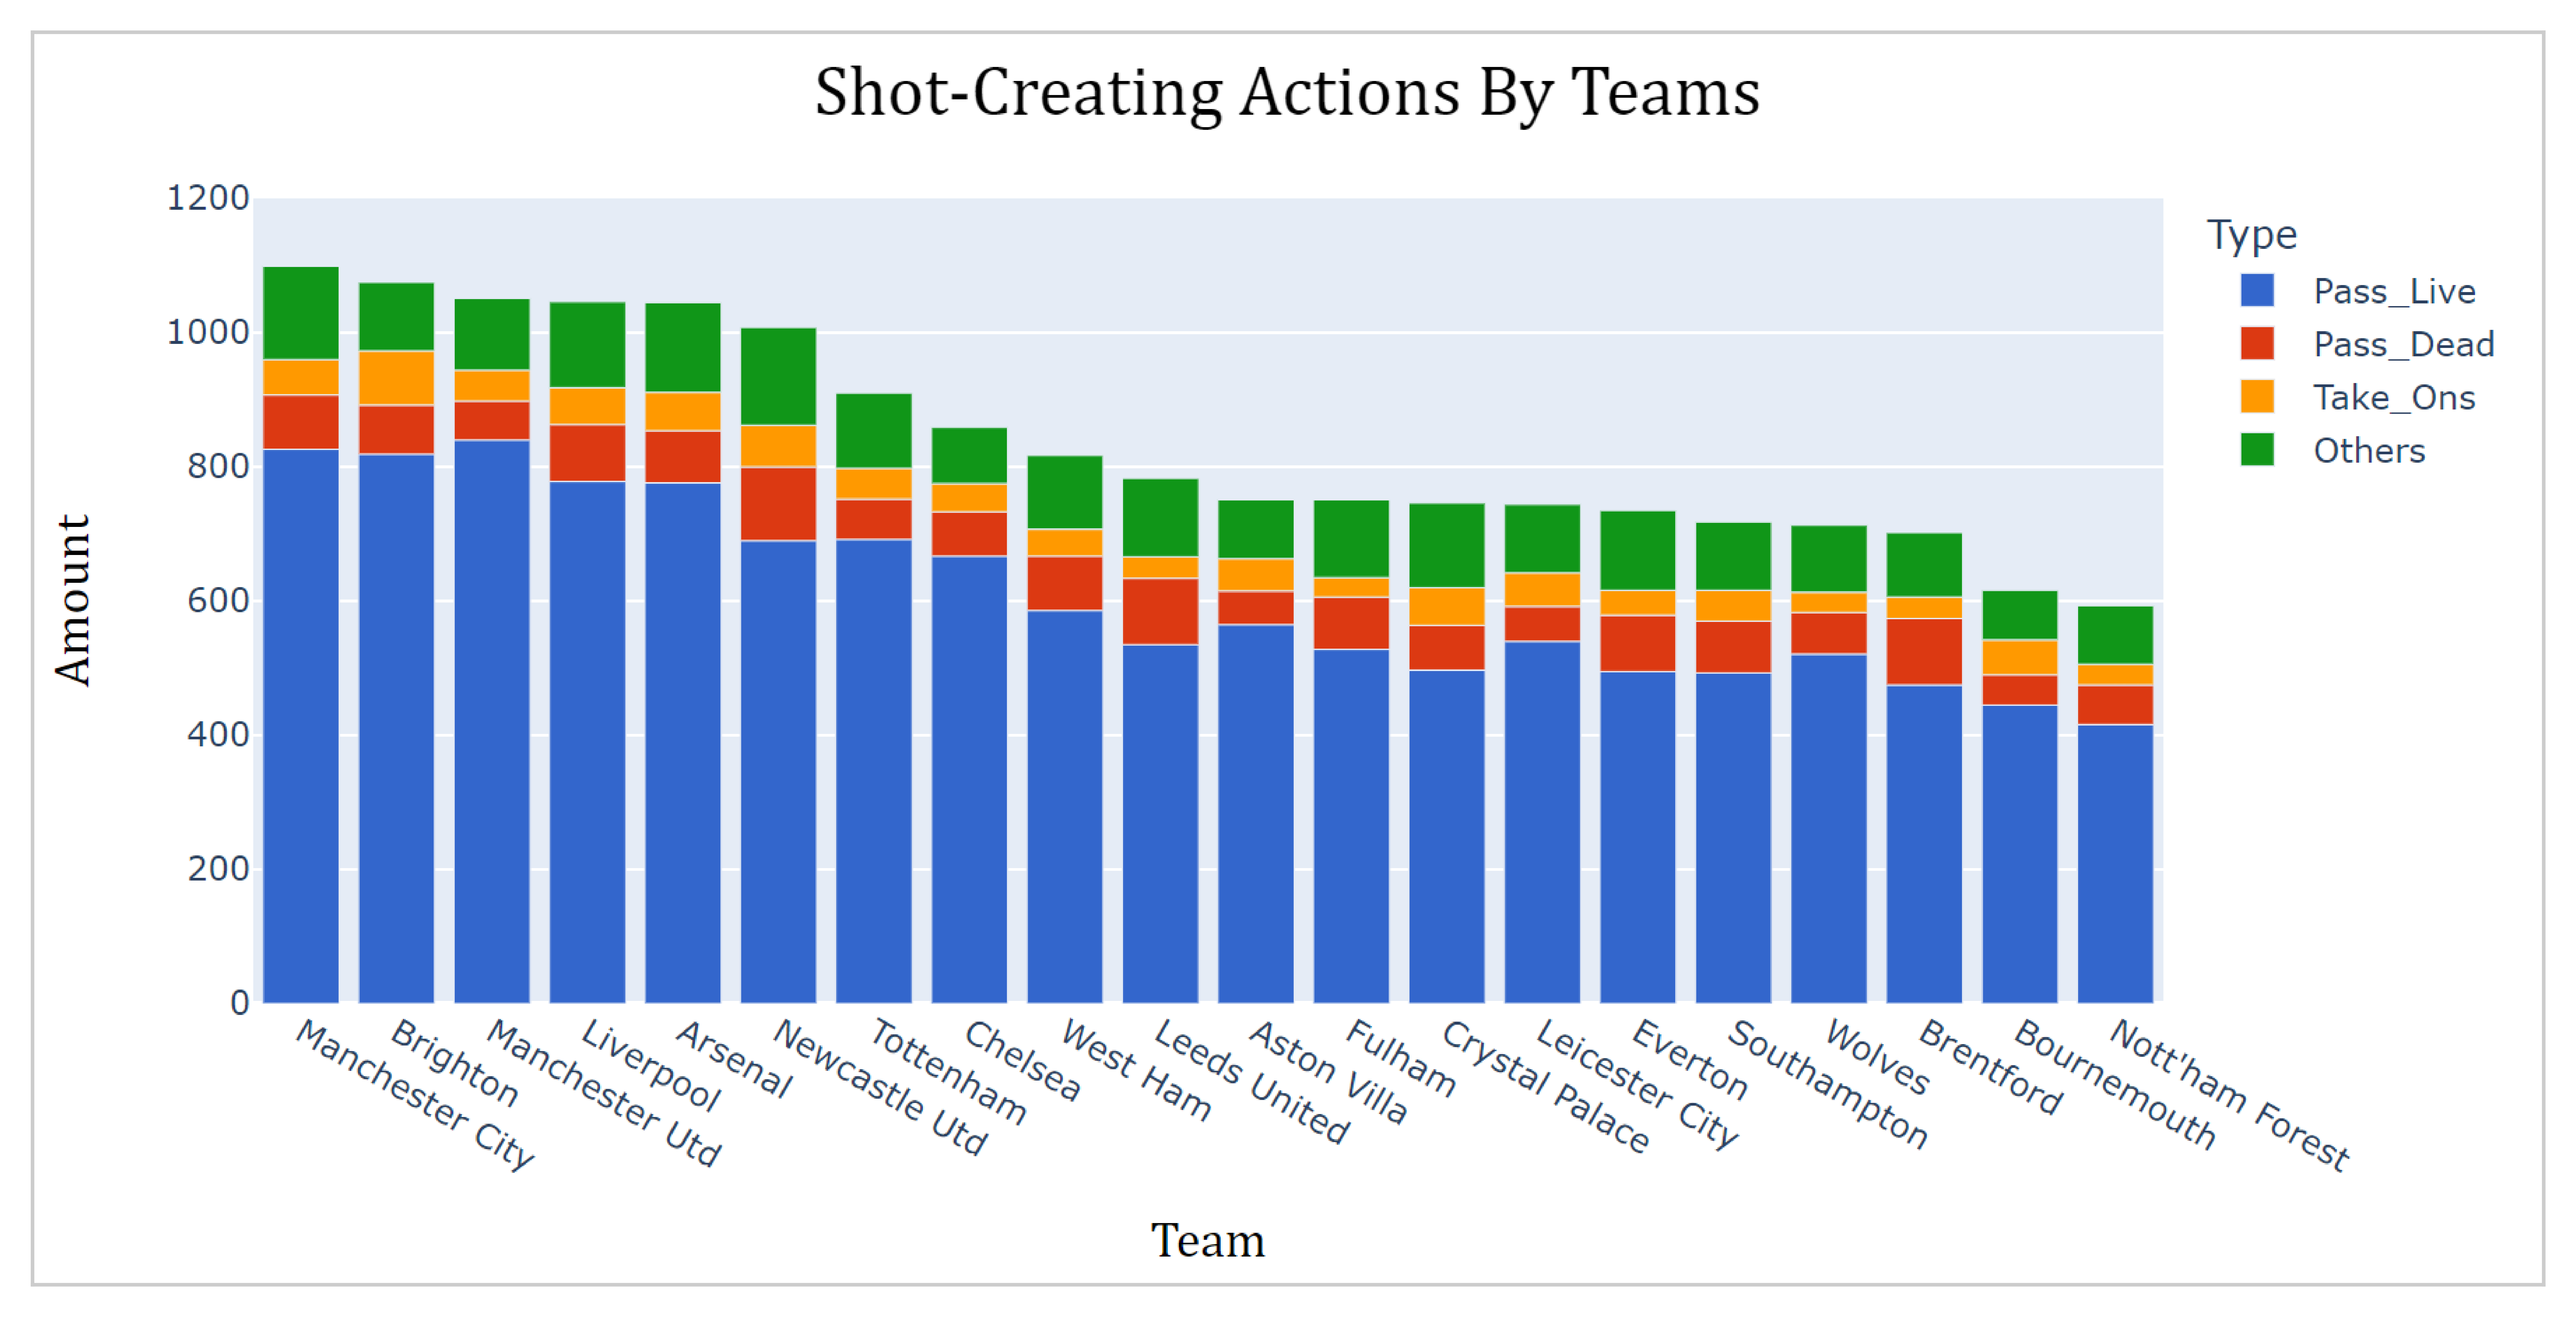

In [10]:
show_image('plots/shot_creation.png')

In [11]:
q4 = """
SELECT t.name AS Team, tg.gca AS GCA, tg.gca_pl AS pass_live, tg.gca_pd AS pass_dead, tg.gca_to AS take_ons
FROM teamGSC as tg
JOIN team t
ON t.id = tg.team_id
"""
cols = ['Team', 'GCA', 'Pass_Live', 'Pass_Dead', 'Take_Ons']

df_gca = prepare_data(q4, con, cols)

df_gca['Others'] = df_gca['GCA'] - df_gca[['Pass_Live', 'Pass_Dead', 'Take_Ons']].sum(axis=1)
df_pivot_gca = df_gca.melt(id_vars=['Team', 'GCA'], value_vars=['Pass_Live', 'Pass_Dead', 'Take_Ons', 'Others'], var_name='Type', value_name='Amount')

total_amount = df_pivot_gca.groupby('Team')['Amount'].sum().reset_index()
df_pivot_gca = pd.merge(df_pivot_gca, total_amount, on='Team', suffixes=('', '_Total'))
df_pivot_gca = df_pivot_gca.sort_values('Amount_Total', ascending=False)

fig = px.bar(
    df_pivot_gca, 
    x='Team', y='Amount', color='Type', 
    color_discrete_sequence=px.colors.qualitative.G10, 
    category_orders={'Type': ['Pass_Live', 'Pass_Dead', 'Take_Ons', 'Others']}
)

fig.update_layout(
    title='Goal-Creating Actions By Teams',
    title_x=0.5,
    title_font=dict(family='Cambria Math', size=25, color='black')
)

fig.update_yaxes(range=[0,175], title_font=dict(family='Cambria Math', size=18, color='black'), showgrid=True, nticks=10)
fig.update_xaxes(title_font=dict(family='Cambria Math', size=18, color='black'))

fig.show()

**NOTE:** Due to the Github error, plots created with plotly library aren't displayed. 
So for Github purposes I also show image of the plot (for obvious reasons it isn't interactive - like `plotly` plot).

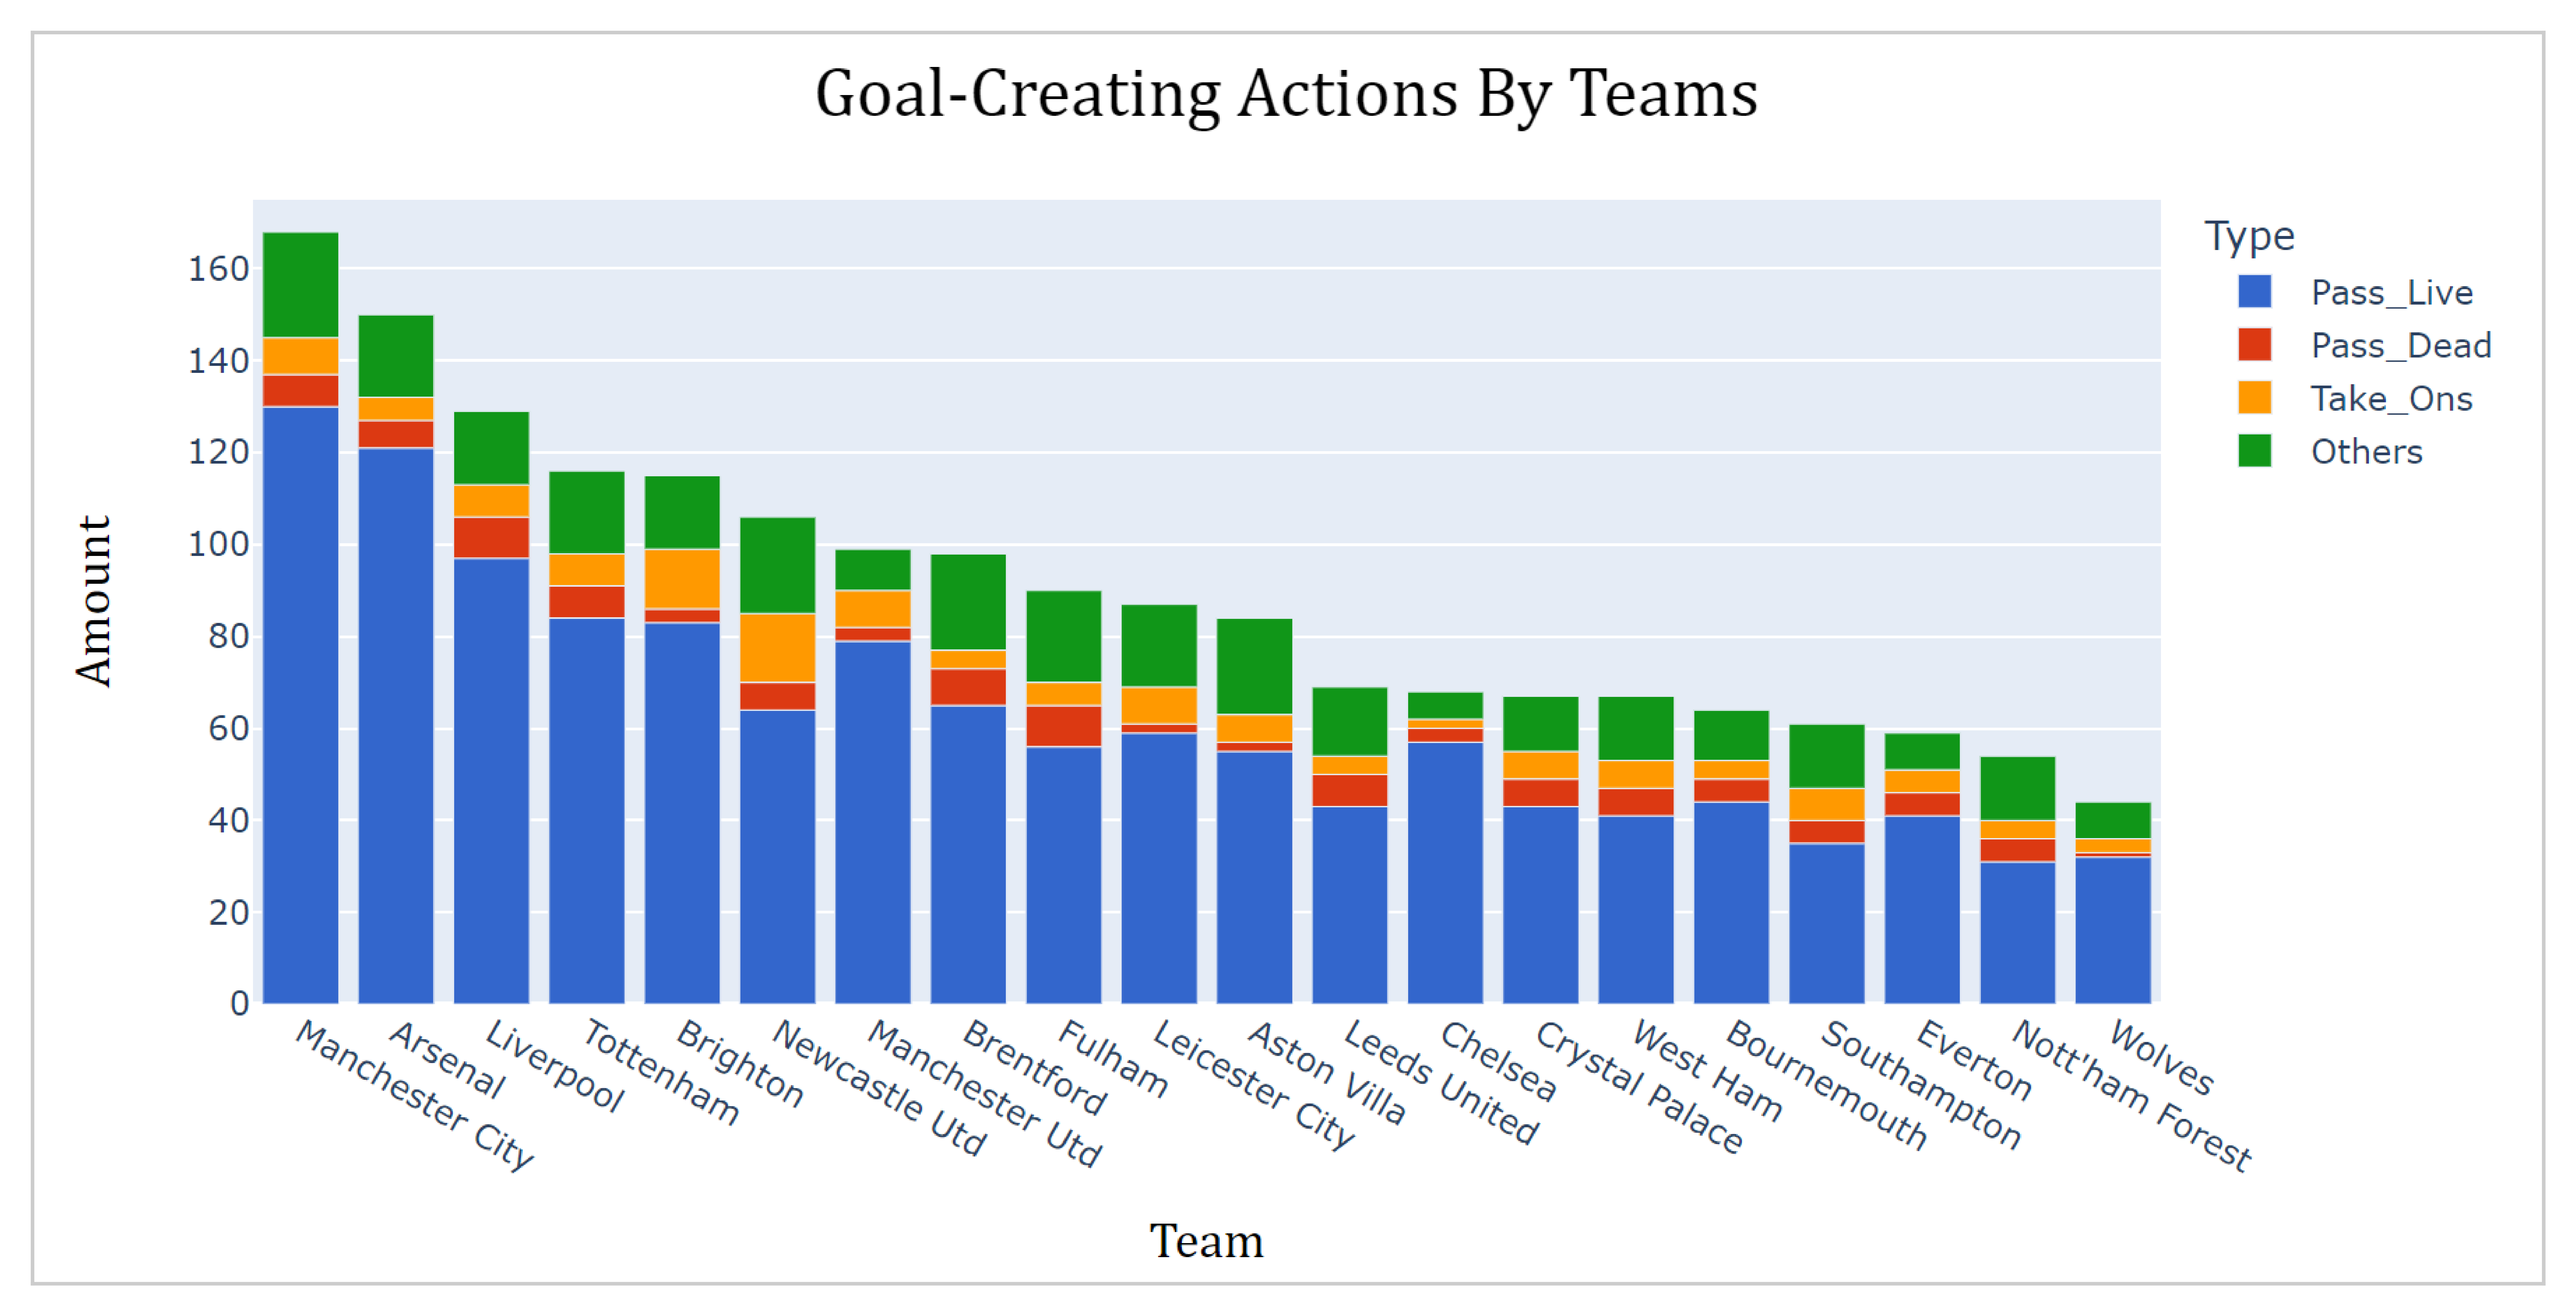

In [12]:
show_image('plots/goal_creation.png')

In [13]:
df_both = pd.merge(df_sca[['Team', 'SCA']], df_gca[['Team', 'GCA']], on='Team')
df_both['Percentage'] = (df_both['GCA']/df_both['SCA']) * 100
df_both = df_both.sort_values('SCA', ascending=False)

trace1 = go.Bar(x=df_both['Team'], y=df_both['SCA'], name='SCA', marker_color='rgb(45, 135, 237)')
trace2 = go.Bar(x=df_both['Team'], y=df_both['GCA'], name='GCA', marker_color='rgb(184, 76, 55)',
                text=df_both['Percentage'].apply(lambda x: f'{int(x)}%'), textposition='outside', textfont=dict(color='white'))

layout = go.Layout(
    title='Shot-Creating and Goal-Creating Actions By Teams',
    title_x=0.5,
    title_font=dict(family='Cambria Math', size=25, color='black'),
    barmode='overlay',
    legend_title_text='Type:'
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.update_yaxes(range=[0,1200], title_text='Amount', title_font=dict(family='Cambria Math', size=18, color='black'), nticks=10)
fig.update_xaxes(title_text='Team', title_font=dict(family='Cambria Math', size=18, color='black'))

fig.show()

**NOTE:** Due to the Github error, plots created with plotly library aren't displayed. 
So for Github purposes I also show image of the plot (for obvious reasons it isn't interactive - like `plotly` plot).

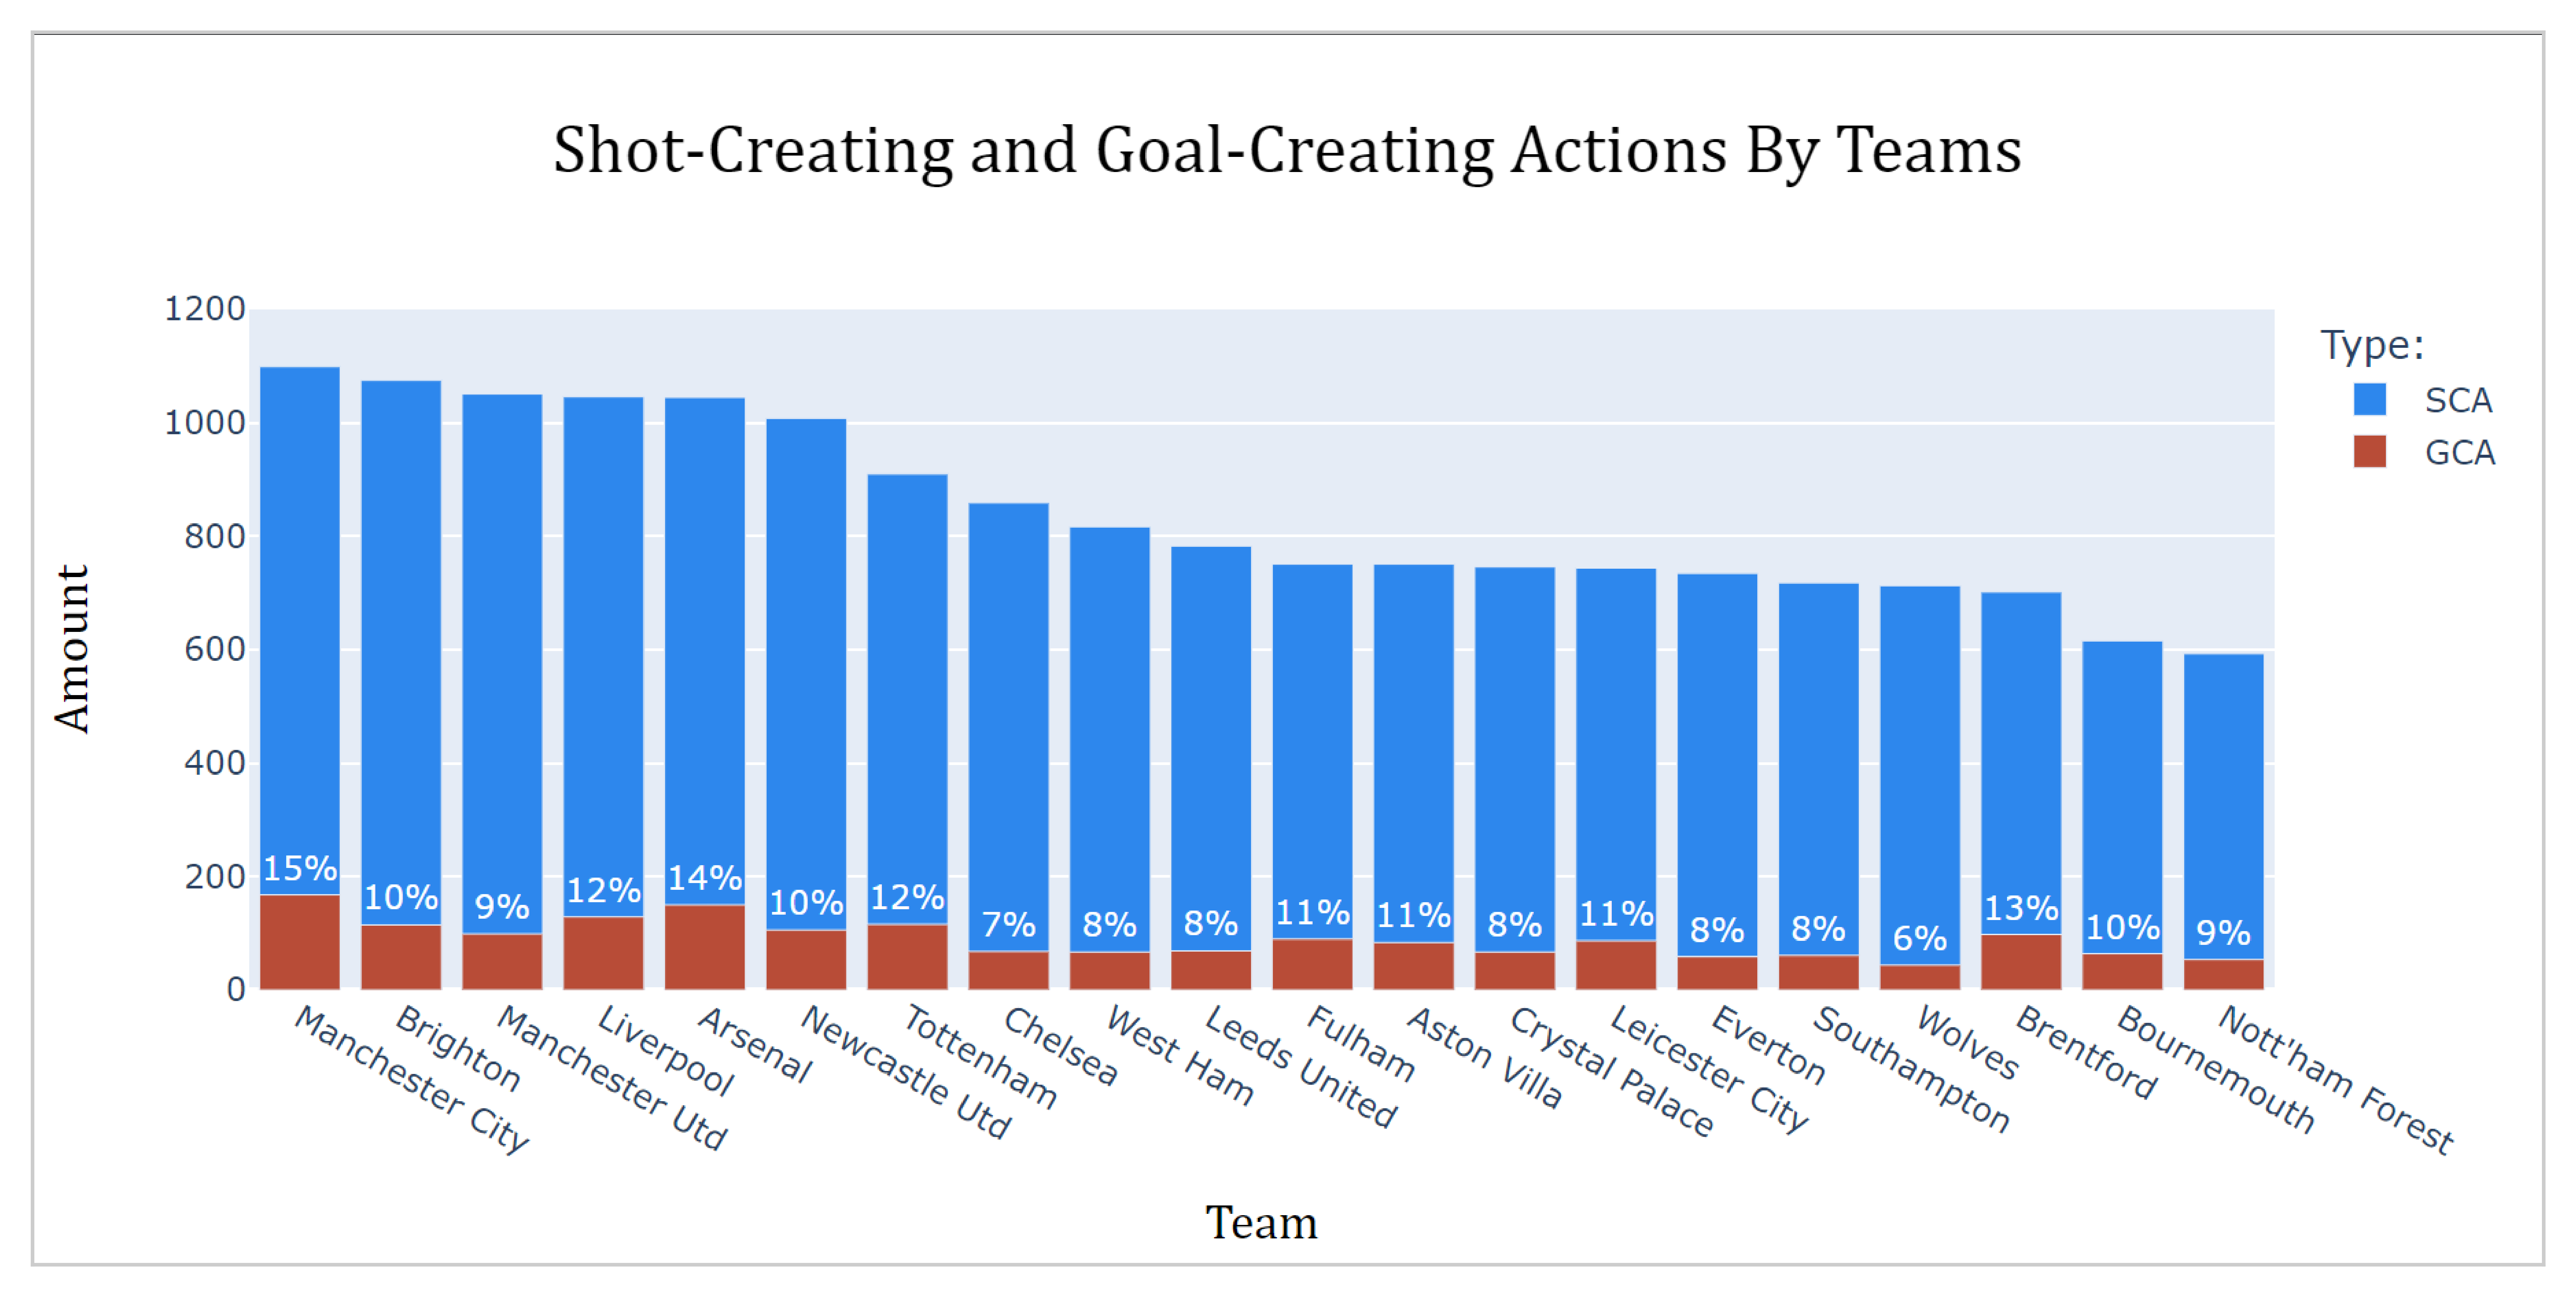

In [14]:
show_image('plots/shot_goal_creation.png')

## ***Average Shot Distance***

In these plots, we examine how data on average shot distance is distributed across teams. The first plot displays this statistic for all teams, while the second plot focuses on the teams that finished the season in the top six (a significant achievement in England, as only the first six teams qualify for UEFA tournaments).

Observing the plots, we notice a trend: generally, stronger teams exhibit less variability in their average shot distance, whereas weaker teams display greater variability. This phenomenon could be attributed to the fact that weaker teams often shoot from less advantageous positions, taking opportunities whenever they arise. In contrast, stronger teams can strategically prepare situations and make more informed decisions about when to take a shot.

In [15]:
q5 = """
SELECT p.name AS Player, t.name AS Team, ps.dist
FROM team t
JOIN player p
ON p.team_id = t.id
JOIN playerSht ps 
ON ps.player_id = p.id
"""
q6 = """
SELECT t.name, ts.pts 
FROM teamStd ts
JOIN team t 
ON t.id = ts.team_id
"""
cols = ['Player', 'Team', 'Average Shot Distance']
cols2 = ['Team', 'Points']

df = prepare_data(q5, con, cols)
df2 = prepare_data(q6,con, cols2)

df2['Place'] = df2['Points'].rank(method='first', ascending=False)

df = df.merge(df2[['Team', 'Place']], on='Team', how='left')
df = df.sort_values(['Place'])

def str_place(place):
    if place == 1:
        return '1st'
    elif place == 2:
        return '2nd'
    elif place == 3:
        return '3rd'
    else:
        return f'{int(place)}th'
    
df['Place_str'] = df['Place'].apply(str_place)

df_top6 = df[df['Place'] <= 6.0]

fig1 = px.violin(df, y='Average Shot Distance', x='Team',  box=False, points='all', hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.D3)
fig1.update_layout(title_text='Average Shot Distance By Team', title_font=dict(family='Cambria Math', size=25, color='black'), title_x=0.5)
fig1.update_yaxes(range=[0,45], title_text='Distance [m]', title_font=dict(family='Cambria Math', size=18, color='black'), nticks=10)
fig1.update_xaxes(title_text='Team', title_font=dict(family='Cambria Math', size=18, color='black'))

fig2 = px.violin(df_top6, y='Average Shot Distance', x='Team',  box=False, points='all', hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.D3)
fig2.update_layout(title_text='Average Shot Distance - TOP SIX', title_font=dict(family='Cambria Math', size=25, color='black'), title_x=0.5)
fig2.update_yaxes(range=[0,40], title_text='Distance [m]', title_font=dict(family='Cambria Math', size=18, color='black'), nticks=10)
fig2.update_xaxes(title_text='Team', title_font=dict(family='Cambria Math', size=18, color='black'))

for team, place in zip(df['Team'].unique(), df['Place_str'].unique()):
    fig1.add_annotation(dict(font=dict(family='Cambria Math', color="black",size=17),
                            x=team,
                            y=df['Average Shot Distance'][df['Team'] == team].max() + 8,
                            text=place,
                            opacity=0.6,
                            showarrow=False,
                            ))
    
for team, place in zip(df_top6['Team'].unique(), df_top6['Place_str'].unique()):
    fig2.add_annotation(dict(font=dict(family='Cambria Math', color="black",size=22),
                            x=team,
                            y=df['Average Shot Distance'][df['Team'] == team].max() + 8,
                            text=place,
                            opacity=0.6,
                            showarrow=False,
                            ))    

fig1.show()
fig2.show()

**NOTE:** Due to the Github error, plots created with plotly library aren't displayed. 
So for Github purposes I also show image of the plot (for obvious reasons it isn't interactive - like `plotly` plot).

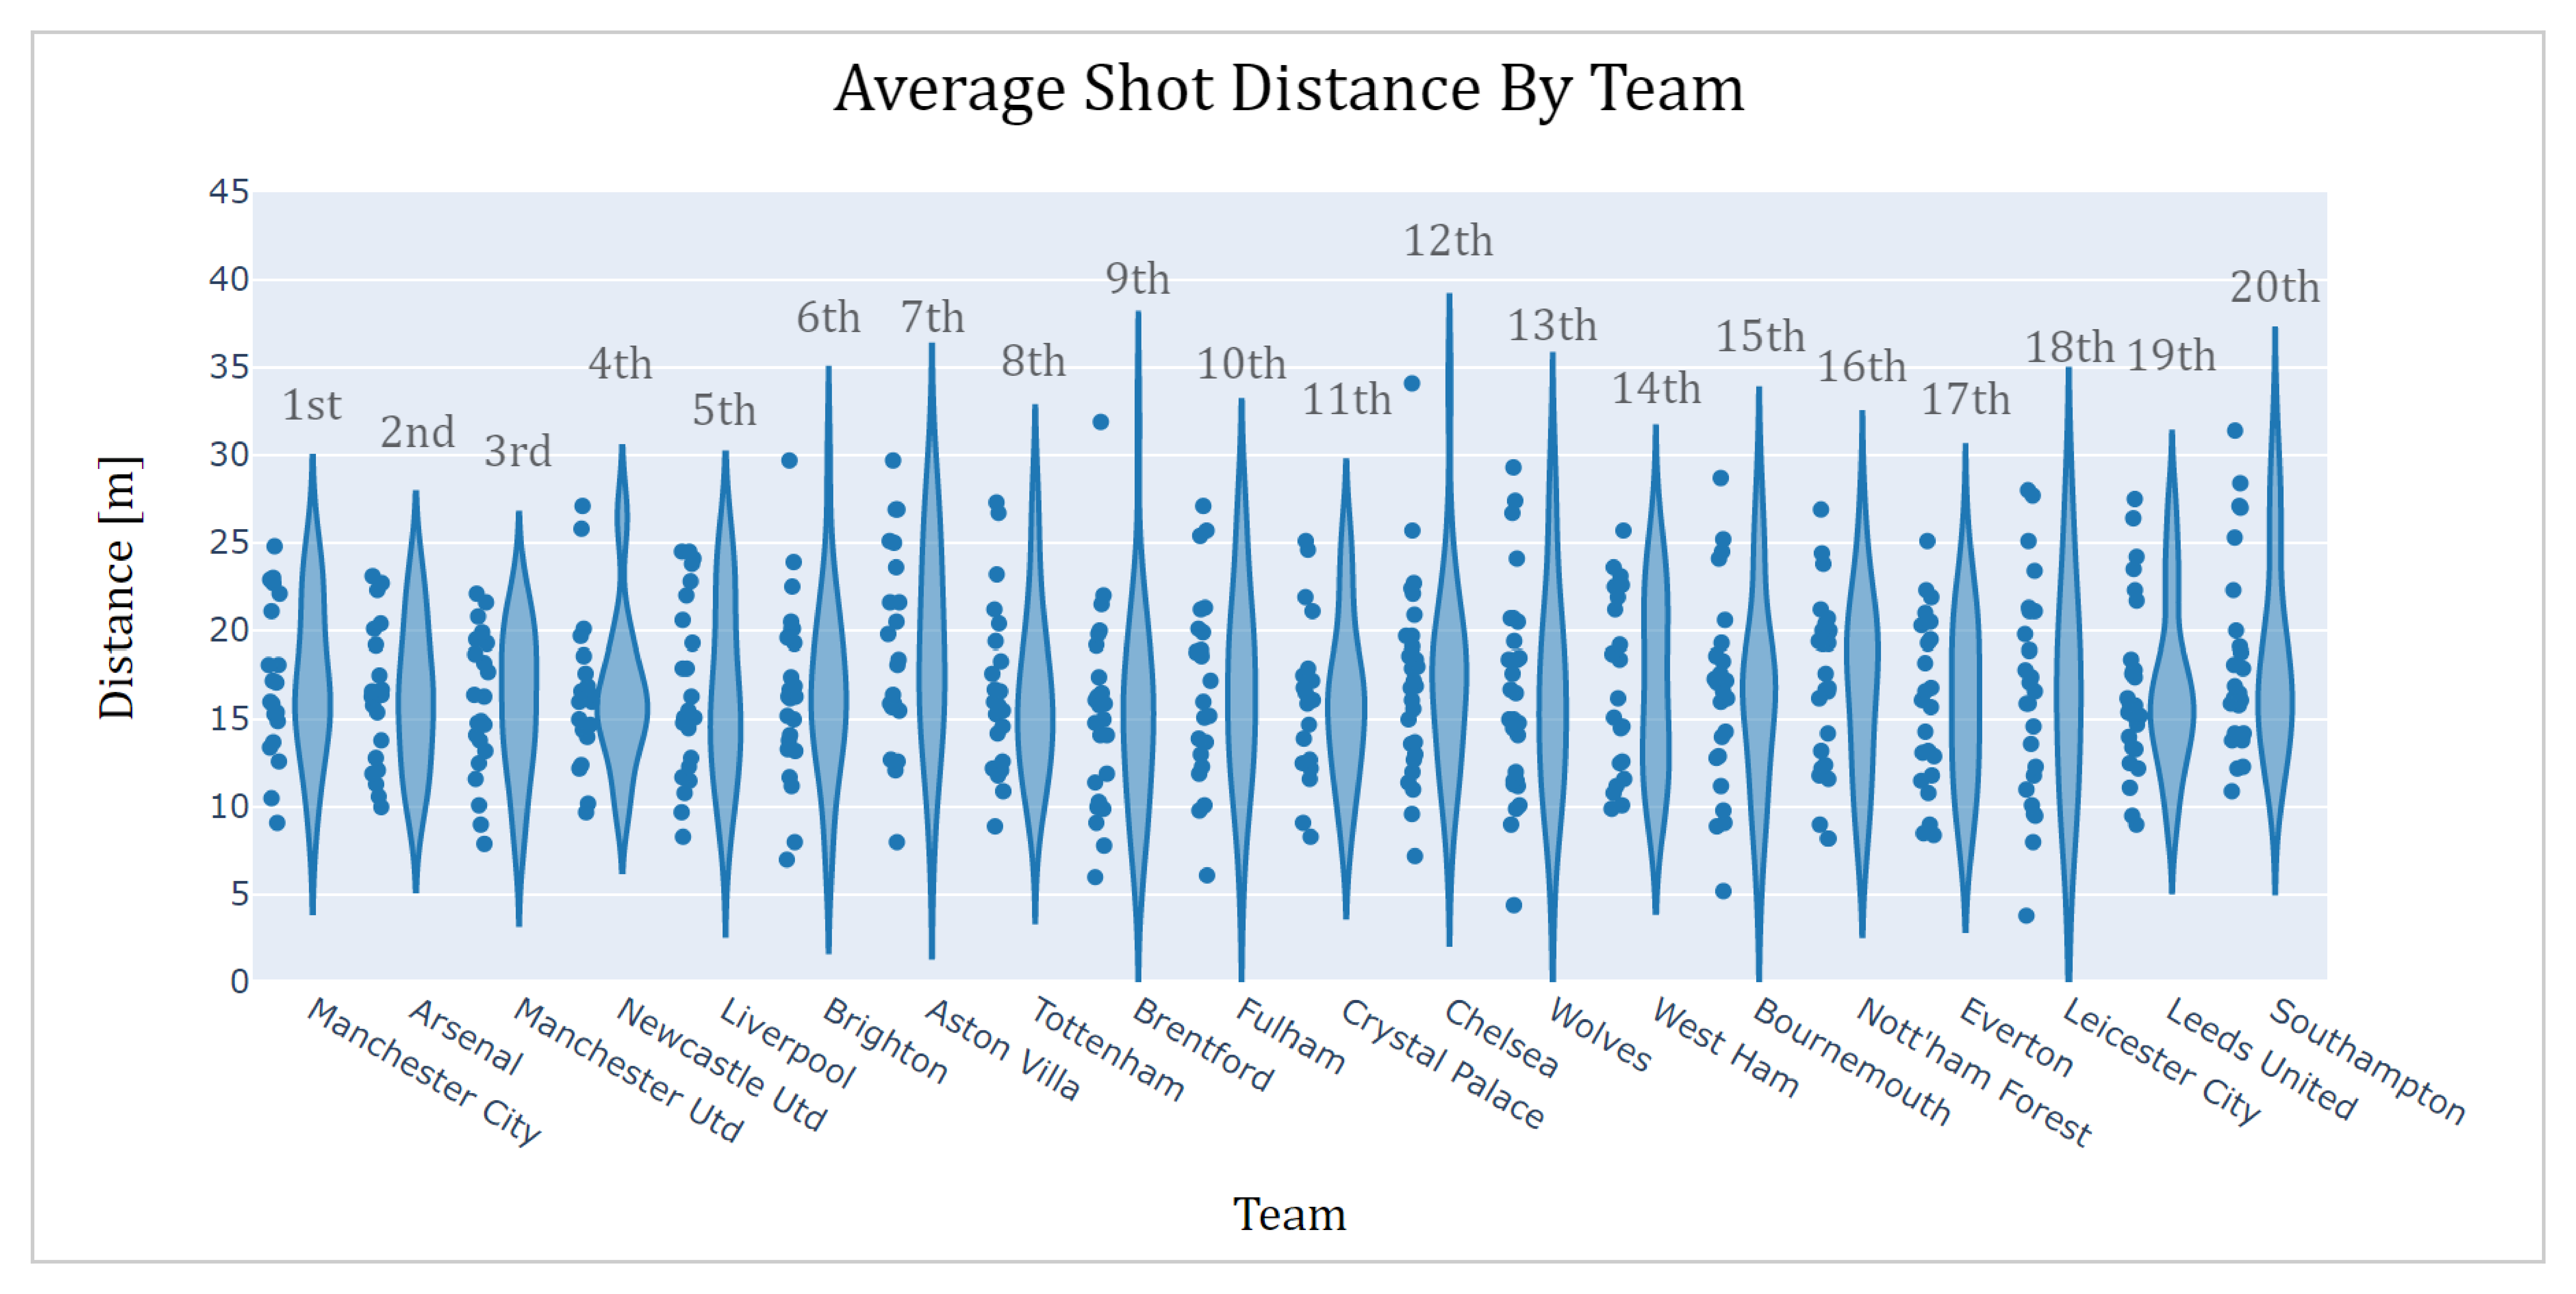

In [17]:
show_image('plots/shot_distance.png')

In [ ]:
show_image('plots/shot_distance_top_six.png')